# Spectral Vertex Nomination

This demo shows how to use the Spectral Vertex Nomination (SVN) class. We will use SVN to nominate vertices in a Stochastic Block Model (SBM)

In [1]:
# imports
import numpy as np
from graspologic.nominate import SpectralVertexNomination
from graspologic.simulations import sbm
from graspologic.plot import heatmap
from matplotlib import pyplot as plt

%matplotlib inline

## What is Spectral Vertex Nomination?

Given a graph $G=(V,E)$ and a subset of $V$ called $S$ (the "seed"), Single Graph Vertex Nomination is the problem of ranking all $V$ ordered by degree of relation to members of $S$.
Spectral Vertex Nomination (SVN) solves the Vertex Nomination problem by embedding a graph's adjacency matrix into a low dimensional euclidean space, then using distance based methods to establish relationship between vertices. (See embedding tutorials)

SVN has the advantage of being extremely efficient on very large graphs, and requires very little prior knowledge of a graph's properties or structure. However, it does somewhat conflate the notion of community membership with vertex similarity.
This might not be appropriate for all vertex nomination use cases. Synthetic SBM data, with inherently defined communities, is therefore a good setting for demonstrating SVN.

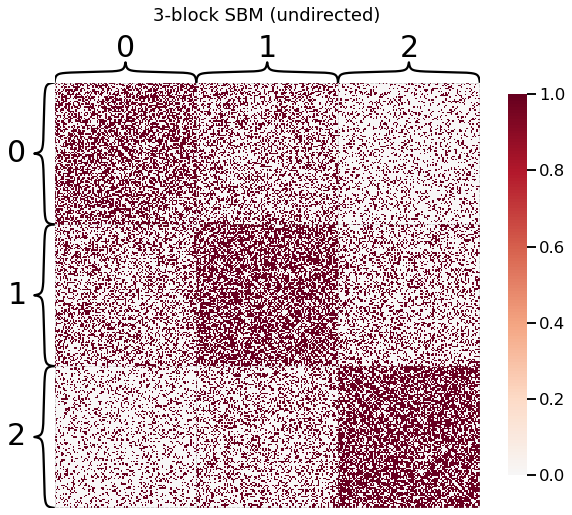

In [2]:
# construct graph from sbm
n_verts = 100
p = np.array([[0.5, 0.35, 0.2],
              [0.35, 0.6, 0.3],
              [0.2, 0.3, 0.65]])
labels = np.array([0] * n_verts + [1] * n_verts + [2] * n_verts)
adj = sbm(3 * [n_verts], p)
fig = heatmap(adj, title='3-block SBM (undirected)', inner_hier_labels=labels)

There are two cases of single graph vertex nomination. In the unattributed case, the seed $S$ is simply a list of any number of vertices in the graph $G$. For each seed vertex $s \in S$, SVN will return a list of the other vertices in order of euclidean distance to $s$.
Here, we select a seed of 5 random vertices.

In [3]:
# define the seed as a random sample of 5 vertices from V.
seed = np.random.choice(3 * n_verts, size=5, replace=False).astype(np.int)
# instantiate a default SVN
svn = SpectralVertexNomination()
# fit to the adjacency matrix
svn.fit(X=adj, y=seed)

The predict method does not require any arguments since this is single graph VN. It generates the nomination list, and returns a tuple of the nomination list itself and the associated distance matrix. The top 5 vertices for each seed are plotted along the first two dimensions of the embedded space.

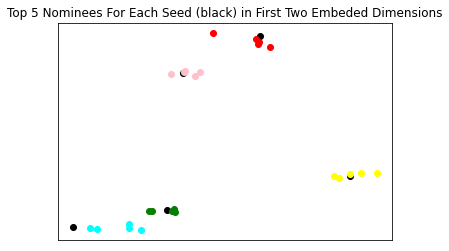

In [4]:
nomination_matrix, distance_matrix = svn.predict()
color = ['red', 'green', 'yellow', 'cyan', 'pink']
plt.scatter(svn.embedding[seed, 0], svn.embedding[seed, 1], c='black')
for i in range(nomination_matrix.shape[1]):
    plt.scatter(svn.embedding[nomination_matrix[1:6, i], 0],
                svn.embedding[nomination_matrix[1:6, i], 1],
                c=color[i])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Top 5 Nominees For Each Seed (black) in First Two Embeded Dimensions')

In the attributed case, seed vertices are labelled with an attribute. Here this is achieved by passing the seed as a two dimensional array of seed indices and attributes.
Now, instead of nominating for each seed vertex, we want to nominate for each unique attribute present in the seed set.

To demonstrate the effectiveness of vertex nomination, we will nominate 100 times on different instance of the same sbm with different seeds, and then visualize probability of correctness at each position of the nomination list.

In [8]:
n_verts = 100
group1_correct = np.zeros(3 * n_verts)
group2_correct = np.zeros(3 * n_verts)
group3_correct = np.zeros(3 * n_verts)
labels = np.array([0] * n_verts + [1] * n_verts + [2] * n_verts)
for i in range(100):
    adj = sbm(3 * [n_verts], p)
    # define the seed as a random sample of 30 vertices from V.
    seed = np.random.choice(3 * n_verts, size=30, replace=False).astype(np.int)
    # attribute them according to block membership in the sbm
    seed = np.concatenate([seed.reshape(-1,1), labels[seed].reshape(-1, 1)], axis=1)
    nomination_matrix, _ = svn.fit_predict(adj, seed)
    group1_correct[np.argwhere(labels[nomination_matrix.T[0]] == 0)] += 1
    group2_correct[np.argwhere(labels[nomination_matrix.T[1]] == 1)] += 1
    group3_correct[np.argwhere(labels[nomination_matrix.T[2]] == 2)] += 1
g1_correct_prob = group1_correct / 100
g2_correct_prob = group2_correct / 100
g3_correct_prob = group3_correct / 100


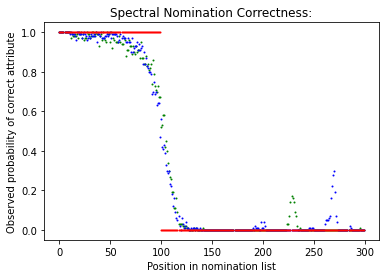

In [9]:
from matplotlib import pyplot as plt
plt.scatter(np.arange(g1_correct_prob.shape[0]), g1_correct_prob, s=1, color='green')
plt.scatter(np.arange(g2_correct_prob.shape[0]), g2_correct_prob, s=1, color='blue')
plt.scatter(np.arange(g3_correct_prob.shape[0]), g3_correct_prob, s=1, color='red')
plt.xlabel('Position in nomination list')
plt.ylabel('Observed probability of correct attribute')
plt.title('Spectral Nomination Correctness:')
plt.show()


The top 100 nominees for attribute 3 (red) are always in block 3 in the sbm! The others aren't perfect, but still have very high probability of correctness.
